### Model 2 volume prediction

In [1]:
import math, pickle, warnings
from pathlib import Path
import os, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_recall_fscore_support,
                             mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score,f1_score)
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_tabnet.tab_model import TabNetRegressor
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
SEED = 1
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
CSV_PATH = "./data/processed_csv.csv"
BASE_FEATS = ["a","b","c","alpha","beta","gamma"]
TARGET     = "vol"
TEST_SIZE  = 0.2
df = pd.read_csv(CSV_PATH).dropna(subset=BASE_FEATS+[TARGET]).copy()

In [5]:
def analytic_volume(a,b,c,alpha,beta,gamma):
    a,b,c = map(np.asarray,(a,b,c))
    alpha,beta,gamma = np.deg2rad(alpha), np.deg2rad(beta), np.deg2rad(gamma)
    cos_a, cos_b, cos_c = np.cos(alpha), np.cos(beta), np.cos(gamma)
    rad = 1 - cos_a**2 - cos_b**2 - cos_c**2 + 2*cos_a*cos_b*cos_c
    rad = np.clip(rad, 0, None)
    return a*b*c*np.sqrt(rad)

df["v_formula"] = analytic_volume(df["a"],df["b"],df["c"],
                                  df["alpha"],df["beta"],df["gamma"])
df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=["v_formula"])

X_raw = df[BASE_FEATS].values.astype(np.float32)
v_formula = df["v_formula"].values.reshape(-1,1).astype(np.float32)
y_log  = np.log1p(df[TARGET].values.astype(np.float32))

scaler = StandardScaler().fit(X_raw)
X_raw  = scaler.transform(X_raw).astype(np.float32)

X_train, X_test, vf_train, vf_test, y_train, y_test = train_test_split(
    X_raw, v_formula, y_log, test_size=TEST_SIZE, random_state=42)

# tensors
def t(a): return torch.tensor(a, dtype=torch.float32)
train_ds = TensorDataset(t(X_train), t(vf_train), t(y_train.reshape(-1,1)))
test_ds  = TensorDataset(t(X_test),  t(vf_test),  t(y_test.reshape(-1,1)))

BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

In [6]:
class SEBlock(nn.Module):
    def __init__(self, dim, r=8):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(dim, dim//r),
                                nn.ReLU(True),
                                nn.Linear(dim//r, dim),
                                nn.Sigmoid())
    def forward(self,x):
        w = self.fc(x.mean(0, keepdim=True))
        return x * w

class ResBlock(nn.Module):
    def __init__(self, dim, p=0.2):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(True),
            nn.Dropout(p),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim))
        self.se = SEBlock(dim)
        self.act= nn.ReLU(True)
    def forward(self,x):
        out = self.ff(x)
        out = self.se(out)
        return self.act(out + x)

class WideDeepNet(nn.Module):
    def __init__(self, in_deep, p=0.2):
        super().__init__()
        layers_dim = [512,512,256,256,128,128,64,64,32,16]
        deep = []
        prev = in_deep
        for d in layers_dim:
            deep.extend([nn.Linear(prev,d), nn.BatchNorm1d(d), nn.ReLU(True), nn.Dropout(p)])
            deep.append(ResBlock(d, p))
            prev = d
        self.deep = nn.Sequential(*deep)
        self.fusion = nn.Sequential(
            nn.Linear(prev+1, 64), nn.ReLU(True),
            nn.Linear(64, 1)
        )
    def forward(self, x_deep, x_wide):
        h = self.deep(x_deep)
        z = torch.cat([h, x_wide], dim=1)
        return self.fusion(z)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = WideDeepNet(in_deep=len(BASE_FEATS)).to(device)

In [7]:
EPOCHS, PATIENCE = 300, 25
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

hist_1, best_val, wait, best_state = {"tr":[],"va":[]}, np.inf, 0, None
t0 = time.time()
for ep in range(1,EPOCHS+1):
    model.train(); run, n = 0.,0
    for xb,wb,yb in train_loader:
        xb,wb,yb = xb.to(device), wb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb,wb), yb)
        loss.backward(); optimizer.step()
        run += loss.item()*xb.size(0); n += xb.size(0)
    tr = run/n
    model.eval(); run,n = 0.,0
    with torch.no_grad():
        for xb,wb,yb in test_loader:
            run += criterion(model(xb.to(device), wb.to(device)), yb.to(device)).item()*xb.size(0)
            n += xb.size(0)
    va = run/n
    hist_1["tr"].append(tr); hist_1["va"].append(va); scheduler.step()
    if va < best_val - 1e-4:
        best_val, best_state, wait = va, model.state_dict(), 0
    else: wait += 1
    if ep==1 or ep%5==0:
        print(f"Epoch {ep:3}/{EPOCHS} | val_MSE={va:.4f}")
    if wait >= PATIENCE: break
print(f"Training done in {(time.time()-t0)/60:.1f} min – best val MSE={best_val:.4f}")
model.load_state_dict(best_state)


Epoch   1/300 | val_MSE=0.0403
Epoch   5/300 | val_MSE=0.0223
Epoch  10/300 | val_MSE=0.0176
Epoch  15/300 | val_MSE=0.0169
Epoch  20/300 | val_MSE=0.0200
Epoch  25/300 | val_MSE=0.0193
Epoch  30/300 | val_MSE=0.0189
Epoch  35/300 | val_MSE=0.0225
Epoch  40/300 | val_MSE=0.0142
Epoch  45/300 | val_MSE=0.0212
Epoch  50/300 | val_MSE=0.0187
Training done in 5.5 min – best val MSE=0.0136


<All keys matched successfully>

In [8]:
model.eval(); preds=[]
with torch.no_grad():
    for xb,wb,_ in test_loader:
        preds.append(model(xb.to(device), wb.to(device)).cpu())
y_pred = np.expm1(torch.cat(preds).numpy().flatten())
y_true = np.expm1(y_test.flatten())

mse, mae, r2 = (mean_squared_error(y_true,y_pred),
                mean_absolute_error(y_true,y_pred),
                r2_score(y_true,y_pred))
print(f"\nResults  •  MSE={mse:.3f}  MAE={mae:.3f}  R²={r2:.4f}")


Results  •  MSE=1.191  MAE=0.123  R²=0.2708


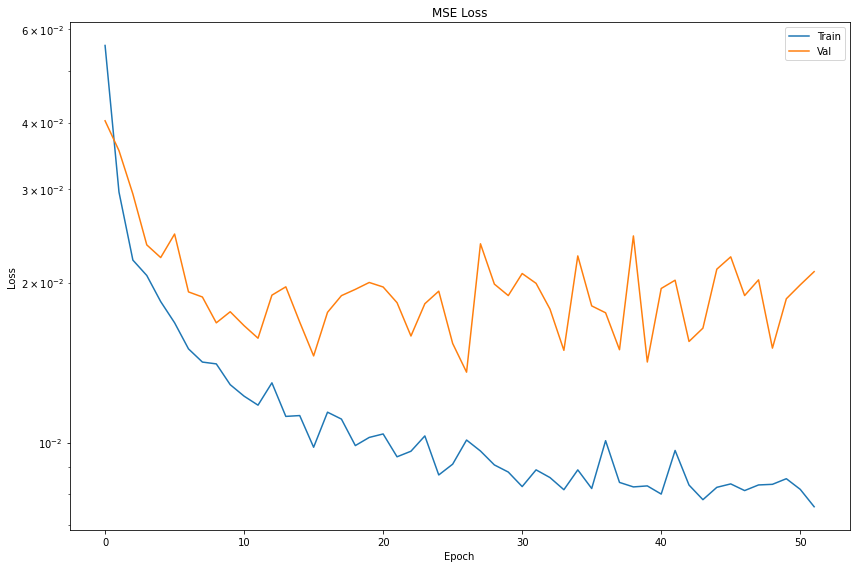

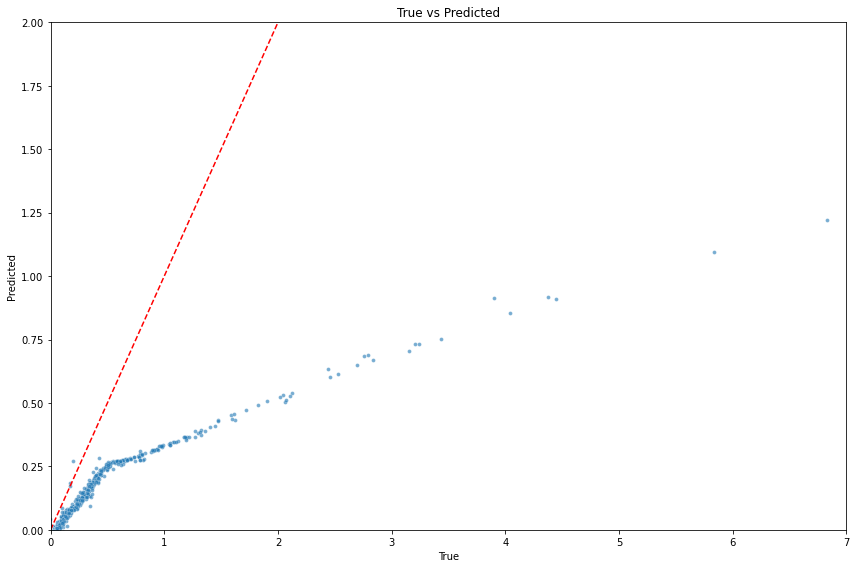

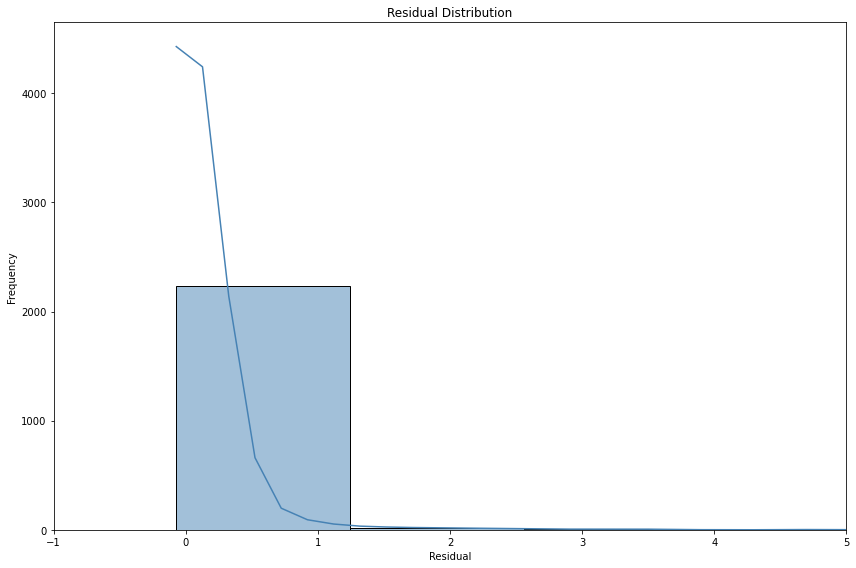

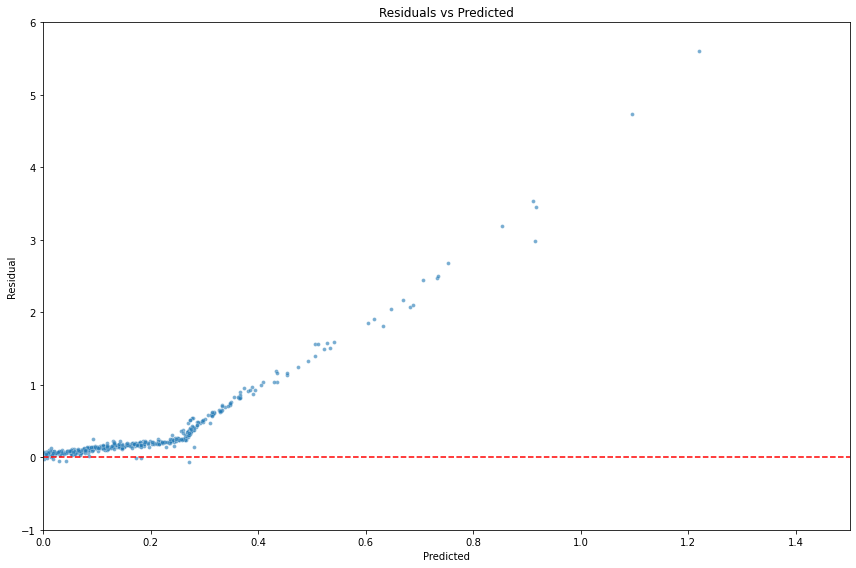

In [9]:
# MSE Loss plot
plt.figure(figsize=(12, 8))
plt.plot(hist_1["tr"], label="Train")
plt.plot(hist_1["va"], label="Val")
plt.yscale("log")
plt.title("MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# True vs Predicted scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_true, y=y_pred, s=15, alpha=0.6)
mx = max(y_true.max(), y_pred.max())
plt.plot([0, mx], [0, mx], 'r--')
plt.title("True vs Predicted")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.xlim(0, 7)
plt.ylim(0, 2)
plt.tight_layout()
plt.show()

# Residual distribution
res = y_true - y_pred
plt.figure(figsize=(12, 8))
sns.histplot(res, kde=True, bins=30, color="steelblue")
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.xlim(-1, 5)
plt.tight_layout()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_pred, y=res, s=15, alpha=0.6)
plt.axhline(0, ls='--', c='red')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.ylim(-1,6)
plt.xlim(0, 1.5)
plt.tight_layout()
plt.show()

In [10]:
parent_dir    = "Models"
model_name    = "Model 2"
model_dir     = os.path.join(parent_dir, model_name)

try:
    os.mkdir(parent_dir)
    print(f"Directory '{parent_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{parent_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{parent_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")

try:
    os.mkdir(model_dir)
    print(f"Directory '{model_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{model_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{model_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")

torch.save(
    model.state_dict(),
    os.path.join(model_dir, f"{model_name} volume_residual_mlp.pt")
)

print(f"\nSaved files to '{model_dir}':")
print(f"  - {model_name} volume_residual_mlp.pt")

Directory 'Models' already exists.
Directory 'Models\Model 2' already exists.

Saved files to 'Models\Model 2':
  - Model 2 volume_residual_mlp.pt
